In [1]:
# Author: Morpheus Hsieh
# Ref: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division  

import os, sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

In [2]:
ProcessedPath = r'D:\GitWork\ants_and_bees\processed'

normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(ProcessedPath, x), data_transforms[x])
    for x in ['train', 'valid']
}

trainSet = image_datasets['train']
validSet = image_datasets['valid']

class_names = trainSet.classes
print('classes: ', class_names)

class_indexes = trainSet.class_to_idx
print('class to index: ', class_indexes)

print()
print('size: ', len(trainSet))

trainX, trainY = trainSet[0]
print('\nimage:')
print(trainX)
print('label:', trainY)

classes:  ['ants', 'bees']
class to index:  {'ants': 0, 'bees': 1}

size:  244

image:
tensor([[[-0.7308, -0.7308, -0.6965,  ..., -0.6965, -0.6794, -0.6452],
         [-0.7308, -0.7479, -0.7308,  ..., -0.6794, -0.6965, -0.6623],
         [-0.6965, -0.6965, -0.7308,  ..., -0.6623, -0.6794, -0.6794],
         ...,
         [-0.5938, -0.5938, -0.5938,  ..., -0.6109, -0.6281, -0.6452],
         [-0.5938, -0.5938, -0.5938,  ..., -0.6281, -0.6281, -0.6281],
         [-0.6109, -0.6109, -0.5938,  ..., -0.6452, -0.6452, -0.6452]],

        [[ 0.6254,  0.6078,  0.6078,  ...,  0.6078,  0.6254,  0.6604],
         [ 0.6254,  0.5903,  0.5728,  ...,  0.6254,  0.6078,  0.6429],
         [ 0.6779,  0.6429,  0.6078,  ...,  0.6604,  0.6429,  0.6429],
         ...,
         [ 0.8004,  0.8004,  0.8004,  ...,  0.7479,  0.7304,  0.7129],
         [ 0.8004,  0.8004,  0.8004,  ...,  0.7304,  0.7304,  0.7304],
         [ 0.7829,  0.7829,  0.8004,  ...,  0.7304,  0.7129,  0.7304]],

        [[ 2.2740,  2.2740,  

In [3]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    ) for x in ['train', 'valid']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

for i, data in enumerate(trainSet[:10]):
    print('i:',i)
    image, label = data
    print('image:', image)
    print('label:', label)


i: 0
image: tensor([[[-0.7650, -0.7479, -0.7308,  ..., -0.6623, -0.6794, -0.6794],
         [-0.7479, -0.7308, -0.7308,  ..., -0.6794, -0.6623, -0.6623],
         [-0.7308, -0.7137, -0.7308,  ..., -0.6623, -0.6794, -0.6965],
         ...,
         [-0.6109, -0.6452, -0.6452,  ..., -0.6623, -0.6794, -0.6965],
         [-0.6623, -0.6452, -0.6281,  ..., -0.6623, -0.6623, -0.6794],
         [-0.6452, -0.6794, -0.5938,  ..., -0.6794, -0.6794, -0.6794]],

        [[ 0.5903,  0.6078,  0.6078,  ...,  0.6254,  0.6604,  0.6604],
         [ 0.6078,  0.6254,  0.6078,  ...,  0.6254,  0.6779,  0.6604],
         [ 0.6254,  0.6254,  0.6078,  ...,  0.6429,  0.6604,  0.6254],
         ...,
         [ 0.7654,  0.7654,  0.7654,  ...,  0.7304,  0.7129,  0.6954],
         [ 0.7304,  0.7654,  0.7654,  ...,  0.7304,  0.7304,  0.7129],
         [ 0.7479,  0.7829,  0.7654,  ...,  0.7129,  0.7129,  0.7304]],

        [[ 2.2391,  2.2566,  2.2566,  ...,  2.2914,  2.3088,  2.3263],
         [ 2.2566,  2.2740,  2.25

image: tensor([[[0.7762, 0.8789, 1.0159,  ..., 1.4954, 1.5125, 1.4954],
         [0.7933, 0.8618, 0.9817,  ..., 1.4954, 1.4954, 1.5125],
         [0.7933, 0.8276, 0.9132,  ..., 1.5125, 1.5125, 1.5297],
         ...,
         [1.3070, 1.3070, 1.3584,  ..., 1.2899, 1.3755, 1.3927],
         [1.3413, 1.3584, 1.4440,  ..., 1.3413, 1.3755, 1.3927],
         [1.4098, 1.4098, 1.4954,  ..., 1.3242, 1.3413, 1.3584]],

        [[0.9405, 1.0280, 1.2031,  ..., 1.9734, 1.9909, 1.9559],
         [1.0105, 1.0630, 1.1681,  ..., 1.9734, 1.9734, 1.9734],
         [1.0280, 1.0280, 1.0980,  ..., 1.9909, 1.9909, 2.0084],
         ...,
         [1.6232, 1.6758, 1.7633,  ..., 1.7283, 1.8508, 1.8508],
         [1.6232, 1.6758, 1.7983,  ..., 1.7458, 1.7983, 1.7983],
         [1.6758, 1.7283, 1.7983,  ..., 1.6933, 1.7108, 1.7283]],

        [[0.7402, 0.9145, 1.1934,  ..., 1.9777, 1.9951, 1.9777],
         [0.7751, 0.9668, 1.0888,  ..., 1.9777, 1.9951, 1.9777],
         [0.7576, 0.8797, 0.9319,  ..., 1.9777, 1.9

i: 34
image: tensor([[[ 1.7523,  1.7180,  1.6324,  ..., -0.3712, -0.3541, -0.3541],
         [ 1.7352,  1.7180,  1.6495,  ..., -0.3712, -0.3541, -0.3541],
         [ 1.7009,  1.7009,  1.7180,  ..., -0.3541, -0.3712, -0.3712],
         ...,
         [ 1.4269,  1.4098,  1.3927,  ..., -1.3130, -0.9705, -0.8164],
         [ 1.2043,  1.2214,  1.2557,  ..., -1.4158, -1.0904, -0.9705],
         [ 1.1187,  1.1529,  1.2043,  ..., -1.4500, -1.1418, -1.0219]],

        [[ 1.9209,  1.8859,  1.7983,  ..., -0.2500, -0.2325, -0.2325],
         [ 1.9034,  1.8859,  1.8158,  ..., -0.2500, -0.2325, -0.2325],
         [ 1.8683,  1.8683,  1.8859,  ..., -0.2325, -0.2500, -0.2500],
         ...,
         [ 1.5882,  1.5707,  1.5532,  ..., -1.2129, -0.8627, -0.7052],
         [ 1.3606,  1.3782,  1.4132,  ..., -1.3179, -0.9853, -0.8627],
         [ 1.2731,  1.3081,  1.3606,  ..., -1.3529, -1.0378, -0.9153]],

        [[ 2.1346,  2.0997,  2.0125,  ..., -0.0267, -0.0092, -0.0092],
         [ 2.1171,  2.0997,  2.0

i: 54
image: tensor([[[-1.1418, -1.1760, -1.1932,  ..., -1.3987, -1.3987, -1.3987],
         [-1.1418, -1.1589, -1.1932,  ..., -1.3987, -1.3987, -1.3987],
         [-1.1760, -1.1760, -1.1760,  ..., -1.4158, -1.4329, -1.4329],
         ...,
         [-1.2788, -1.2617, -1.2617,  ..., -1.0904, -1.0904, -1.0904],
         [-1.2617, -1.2445, -1.2445,  ..., -0.9192, -0.9192, -0.9192],
         [-1.1589, -1.1418, -1.1418,  ..., -0.7993, -0.7993, -0.7993]],

        [[-1.0553, -1.0553, -1.0378,  ..., -1.3004, -1.3004, -1.3004],
         [-1.0553, -1.0378, -1.0378,  ..., -1.3004, -1.3004, -1.3004],
         [-1.0378, -1.0203, -1.0203,  ..., -1.3179, -1.3179, -1.3354],
         ...,
         [-1.1253, -1.1078, -1.1078,  ..., -0.9503, -0.9678, -0.9678],
         [-1.0903, -1.0728, -1.0728,  ..., -0.8978, -0.8803, -0.8978],
         [-1.0903, -1.1078, -1.1078,  ..., -0.8102, -0.8102, -0.8102]],

        [[-1.6302, -1.6650, -1.6824,  ..., -1.7347, -1.7347, -1.7347],
         [-1.6302, -1.6476, -1.6

i: 74
image: tensor([[[1.5468, 1.6667, 1.5468,  ..., 1.1187, 1.8550, 2.0948],
         [1.7865, 1.6153, 1.6324,  ..., 1.2557, 1.8379, 2.0092],
         [1.5982, 1.6838, 1.7352,  ..., 1.3927, 1.7352, 2.0434],
         ...,
         [0.8104, 0.8961, 1.1872,  ..., 1.3242, 1.7180, 1.8722],
         [0.5193, 0.7077, 1.0502,  ..., 1.3413, 1.5982, 1.6153],
         [0.4337, 0.5364, 0.7933,  ..., 1.2557, 1.4954, 1.5982]],

        [[1.6933, 1.8508, 1.7108,  ..., 1.1155, 1.9384, 2.2185],
         [1.9734, 1.7633, 1.7633,  ..., 1.3081, 1.9034, 2.1134],
         [1.7458, 1.7633, 1.7983,  ..., 1.4307, 1.7983, 2.1485],
         ...,
         [0.8004, 0.9405, 1.2731,  ..., 1.2381, 1.7283, 1.9559],
         [0.5028, 0.7304, 1.0980,  ..., 1.2731, 1.5882, 1.6583],
         [0.3627, 0.5378, 0.7829,  ..., 1.1856, 1.5007, 1.6408]],

        [[1.6988, 1.8383, 1.6814,  ..., 0.8274, 1.6988, 2.1346],
         [1.9428, 1.6814, 1.6814,  ..., 1.0017, 1.6117, 1.9777],
         [1.6640, 1.6814, 1.7860,  ..., 1.106

i: 95
image: tensor([[[-1.6213, -1.6042, -1.6042,  ..., -1.8439, -1.8439, -1.7754],
         [-1.6042, -1.6042, -1.5870,  ..., -1.8439, -1.8439, -1.8268],
         [-1.5870, -1.5870, -1.5699,  ..., -1.8610, -1.8610, -1.8610],
         ...,
         [-1.8610, -1.8268, -1.7754,  ..., -1.8268, -1.7925, -1.7925],
         [-1.7754, -1.7583, -1.7412,  ..., -1.8439, -1.8268, -1.8268],
         [-1.7240, -1.7069, -1.7240,  ..., -1.8439, -1.8439, -1.8439]],

        [[-1.0553, -1.0378, -1.0203,  ..., -1.0728, -1.0728, -1.0728],
         [-1.0203, -1.0203, -1.0028,  ..., -1.0903, -1.0903, -1.0903],
         [-1.0028, -1.0028, -0.9853,  ..., -1.1078, -1.1078, -1.1078],
         ...,
         [-1.4405, -1.3880, -1.3529,  ..., -1.1604, -1.1604, -1.1604],
         [-1.3704, -1.3529, -1.3004,  ..., -1.1954, -1.1954, -1.1954],
         [-1.3179, -1.3004, -1.2654,  ..., -1.2304, -1.2304, -1.2304]],

        [[-1.2119, -1.1944, -1.1770,  ..., -1.7522, -1.7522, -1.7173],
         [-1.1770, -1.1770, -1.1

i: 113
image: tensor([[[ 0.4851,  0.4508,  0.3994,  ...,  0.1597,  0.2282,  0.2796],
         [ 0.2967,  0.3309,  0.3309,  ...,  0.3652,  0.3138,  0.3138],
         [ 0.1083,  0.0912,  0.1939,  ...,  0.6049,  0.4337,  0.3652],
         ...,
         [-1.1418, -1.1932, -1.0733,  ...,  0.7762,  0.6906,  0.6392],
         [-1.3473, -1.3815, -1.2617,  ...,  0.7762,  0.6734,  0.6563],
         [-1.4843, -1.4500, -1.2103,  ...,  0.7591,  0.6906,  0.7077]],

        [[-0.0749, -0.1099, -0.1975,  ..., -0.3725, -0.3375, -0.3025],
         [-0.2150, -0.2325, -0.2325,  ..., -0.3550, -0.3200, -0.2500],
         [-0.3901, -0.4076, -0.3375,  ..., -0.3025, -0.2850, -0.2675],
         ...,
         [-1.5805, -1.5280, -1.3880,  ...,  0.3102,  0.2402,  0.1877],
         [-1.6856, -1.6331, -1.4580,  ...,  0.2927,  0.2227,  0.1877],
         [-1.7556, -1.6331, -1.3354,  ...,  0.2927,  0.2227,  0.1877]],

        [[-0.6715, -0.6541, -0.6367,  ..., -0.6367, -0.5495, -0.5147],
         [-0.7587, -0.7587, -0.

i: 135
image: tensor([[[ 1.0159,  0.9988,  0.9646,  ..., -0.9534, -0.9705, -1.0219],
         [ 0.9817,  0.9646,  0.9132,  ..., -1.0562, -1.0904, -1.1418],
         [ 0.9988,  0.9474,  0.8618,  ..., -1.1760, -1.2274, -1.2959],
         ...,
         [ 1.7523,  1.7352,  1.7523,  ..., -0.2513, -0.2684, -0.3198],
         [ 1.7352,  1.7352,  1.7180,  ..., -0.3712, -0.4054, -0.4568],
         [ 1.7180,  1.7009,  1.7009,  ..., -0.4739, -0.5082, -0.4911]],

        [[ 0.7829,  0.7479,  0.7129,  ..., -1.0028, -1.0553, -1.1253],
         [ 0.7129,  0.6954,  0.6429,  ..., -1.0903, -1.1779, -1.2479],
         [ 0.7129,  0.6429,  0.5728,  ..., -1.2479, -1.3179, -1.3880],
         ...,
         [ 1.7458,  1.6758,  1.6758,  ..., -0.4776, -0.4951, -0.5476],
         [ 1.7108,  1.6583,  1.6408,  ..., -0.6001, -0.6352, -0.6877],
         [ 1.6758,  1.6408,  1.6232,  ..., -0.7227, -0.7577, -0.7927]],

        [[-0.6715, -0.6541, -0.7064,  ..., -1.6127, -1.6302, -1.6476],
         [-0.7413, -0.7413, -0.

i: 155
image: tensor([[[-1.2445, -1.2617, -1.2445,  ..., -1.8097, -1.6898, -1.5357],
         [-1.2445, -1.2445, -1.2274,  ..., -1.8097, -1.6898, -1.5185],
         [-1.2445, -1.2445, -1.2274,  ..., -1.8097, -1.6727, -1.4843],
         ...,
         [-1.6384, -1.6213, -1.6042,  ..., -2.0665, -2.0837, -2.0837],
         [-1.6384, -1.6213, -1.6042,  ..., -2.0665, -2.0665, -2.0837],
         [-1.6384, -1.6213, -1.6042,  ..., -2.0837, -2.0837, -2.0665]],

        [[-0.8627, -0.8803, -0.8627,  ..., -1.6856, -1.5455, -1.4055],
         [-0.8627, -0.8627, -0.8452,  ..., -1.6856, -1.5455, -1.3880],
         [-0.8627, -0.8627, -0.8452,  ..., -1.6856, -1.5455, -1.3880],
         ...,
         [-1.5455, -1.5280, -1.5105,  ..., -2.0007, -2.0007, -2.0182],
         [-1.5455, -1.5280, -1.5105,  ..., -2.0007, -2.0182, -2.0357],
         [-1.5630, -1.5280, -1.5280,  ..., -2.0182, -2.0357, -2.0182]],

        [[-1.2641, -1.2816, -1.2641,  ..., -1.6476, -1.4733, -1.3164],
         [-1.2641, -1.2816, -1.

i: 174
image: tensor([[[ 0.7762,  0.6392,  0.4679,  ...,  2.1975,  2.2318,  2.2147],
         [ 0.9303,  0.7762,  0.6049,  ...,  2.2147,  2.2147,  2.1975],
         [ 1.0502,  0.8961,  0.7248,  ...,  2.1975,  2.2147,  2.1975],
         ...,
         [-0.2171, -0.0629, -0.0116,  ...,  2.2318,  2.2318,  2.2147],
         [-0.2684, -0.0801, -0.0287,  ...,  2.2318,  2.2147,  2.1975],
         [-0.3369, -0.2171, -0.1486,  ...,  2.2318,  2.2147,  2.2318]],

        [[ 0.3102,  0.1877,  0.0126,  ...,  1.8158,  1.7808,  1.7633],
         [ 0.6254,  0.4853,  0.2577,  ...,  1.8683,  1.8333,  1.8158],
         [ 0.8354,  0.6604,  0.4153,  ...,  1.8683,  1.8683,  1.8508],
         ...,
         [ 0.0826,  0.2402,  0.3452,  ...,  0.5903,  0.6078,  0.5903],
         [ 0.0651,  0.2052,  0.3277,  ...,  0.6429,  0.6604,  0.6254],
         [ 0.0126,  0.1877,  0.3102,  ...,  0.6954,  0.6604,  0.6429]],

        [[ 0.0256, -0.0790, -0.2532,  ...,  0.0431,  0.0953,  0.1128],
         [ 0.3393,  0.1825, -0.

i: 193
image: tensor([[[ 2.0092,  1.9578,  2.0434,  ...,  2.1975,  2.1975,  2.1804],
         [ 2.0092,  1.9749,  1.9920,  ...,  2.1975,  2.2147,  2.1975],
         [ 1.8722,  2.0092,  1.9578,  ...,  2.1975,  2.2147,  2.2147],
         ...,
         [ 2.0434,  2.0434,  1.9920,  ...,  2.1462,  2.1804,  2.1633],
         [ 2.0948,  2.0605,  1.9920,  ...,  2.1633,  2.1633,  2.1633],
         [ 2.0777,  2.0605,  2.0434,  ...,  2.1804,  2.1804,  2.1975]],

        [[ 1.3081,  1.3431,  1.3606,  ...,  2.2535,  2.2535,  2.2535],
         [ 1.3606,  1.2731,  1.3256,  ...,  2.2360,  2.2360,  2.2535],
         [ 1.0805,  1.3256,  1.2381,  ...,  2.2185,  2.2360,  2.2360],
         ...,
         [ 1.1856,  1.2381,  1.2031,  ...,  2.1134,  2.1660,  2.1485],
         [ 1.2381,  1.2381,  1.1856,  ...,  2.1485,  2.1485,  2.1485],
         [ 1.2731,  1.2556,  1.1681,  ...,  2.1660,  2.1660,  2.1835]],

        [[-1.7347, -1.7347, -1.7870,  ..., -1.7870, -1.7870, -1.7870],
         [-1.7173, -1.7347, -1.

i: 214
image: tensor([[[-1.1418, -1.1589, -1.1589,  ...,  0.6392,  0.2624,  0.2111],
         [-1.1760, -1.1760, -1.1760,  ...,  0.7248,  0.3481,  0.1597],
         [-1.1932, -1.1932, -1.1932,  ...,  0.6906,  0.3994,  0.1939],
         ...,
         [ 0.2111,  0.2111,  0.2282,  ..., -0.3027, -0.2856, -0.2171],
         [ 0.1597,  0.1939,  0.1939,  ..., -0.3027, -0.2856, -0.2171],
         [ 0.1254,  0.1426,  0.1768,  ..., -0.2684, -0.2513, -0.1999]],

        [[-1.1954, -1.2129, -1.2129,  ..., -1.7206, -1.8782, -1.9482],
         [-1.2304, -1.2304, -1.2304,  ..., -1.6681, -1.8431, -2.0007],
         [-1.2479, -1.2479, -1.2479,  ..., -1.6506, -1.7906, -1.9657],
         ...,
         [-1.5105, -1.5105, -1.4930,  ..., -2.0357, -2.0182, -2.0007],
         [-1.5455, -1.5105, -1.5105,  ..., -2.0357, -2.0182, -2.0182],
         [-1.5630, -1.5455, -1.5280,  ..., -2.0357, -2.0357, -2.0182]],

        [[-1.0550, -1.0898, -1.1073,  ..., -1.2816, -1.5779, -1.7347],
         [-1.0898, -1.0898, -1.

i: 234
image: tensor([[[ 0.2967, -0.0629, -0.4911,  ..., -1.3644, -1.3473, -1.3473],
         [ 0.5536,  0.3652,  0.0056,  ..., -1.3815, -1.3473, -1.3815],
         [ 0.5878,  0.5707,  0.4337,  ..., -1.3987, -1.3644, -1.3987],
         ...,
         [ 0.1083,  0.0912,  0.0741,  ..., -0.7822, -0.8335, -0.8849],
         [ 0.0227, -0.0287, -0.0458,  ..., -0.7993, -0.8507, -0.9020],
         [-0.1486, -0.1999, -0.2342,  ..., -0.8335, -0.8678, -0.9534]],

        [[ 0.5028,  0.2227, -0.0749,  ..., -0.9153, -0.8978, -0.8627],
         [ 0.7129,  0.5728,  0.2577,  ..., -0.9153, -0.8803, -0.9153],
         [ 0.7654,  0.7129,  0.5378,  ..., -0.9153, -0.8978, -0.9328],
         ...,
         [ 0.7129,  0.6954,  0.6779,  ..., -0.4251, -0.4426, -0.4951],
         [ 0.6078,  0.5553,  0.5028,  ..., -0.4076, -0.4776, -0.5476],
         [ 0.3803,  0.3627,  0.3102,  ..., -0.4426, -0.5126, -0.6001]],

        [[-1.3861, -1.6127, -1.7696,  ..., -1.7870, -1.7696, -1.7696],
         [-1.1770, -1.4210, -1.

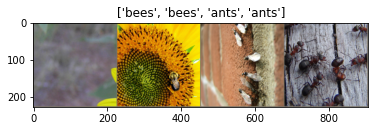

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
print(inputs.shape)
# print(inputs)
print(classes)

torch.Size([4, 3, 224, 224])
tensor([1, 1, 0, 0])


In [6]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print(device)

cuda:0


In [11]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
# Train and evaluate

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.6039 Acc: 0.6762
valid Loss: 0.2200 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5597 Acc: 0.7418
valid Loss: 0.2615 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5722 Acc: 0.7992
valid Loss: 0.2901 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4308 Acc: 0.8279
valid Loss: 0.3226 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5359 Acc: 0.7828
valid Loss: 0.4041 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5204 Acc: 0.7951
valid Loss: 0.3481 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4002 Acc: 0.8156
valid Loss: 0.4607 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3859 Acc: 0.8566
valid Loss: 0.3061 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3485 Acc: 0.8648
valid Loss: 0.3114 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2865 Acc: 0.8689
valid Loss: 0.2566 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3395 Acc: 0.8443
valid Loss: 0.2496 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3291 Acc: 0.8648
valid Loss

In [16]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

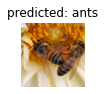

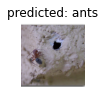

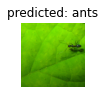

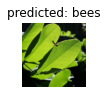

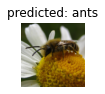

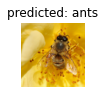

In [17]:
visualize_model(model_ft)